# Manipulate ONS LSOA Mid-Year Estimates from EW to London

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Subset [Lower layer Super Output Area population estimates (National Statistics)](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimatesnationalstatistics) from England & Wales extent to London. 

Inputs are `.xlsx`, outputs will be `.csv` that can be readily joined to [ONS Geographies data](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census). 

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-09-16


In [2]:
import pyproj
import geopandas as gpd
import pandas as pd
from functools import reduce
from pathlib import Path

Read [London 2011 LSOA census geography](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census) for filtering England & Wales data to London only.
> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [3]:
census_path = Path("../data/geographies/census/")
london = gpd.read_file(census_path/"london-2011-lsoa.shp")
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 264.5+ KB


Read and clean population data.

[Original data](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimatesnationalstatistics) downloaded [2022-08-24]. 
>Source: Office for National Statistics licensed under the Open Government Licence.

In [4]:
pop_path = Path("../data/inputs/population/")
pop_filepath = pop_path/"SAPE22DT13-mid-2019-lsoa-Broad_ages-estimates-unformatted.xlsx"
year_str = str(2019)

#pop_filepath = pop_path/"sape23dt13mid2020lsoabroadagesestimatesunformatted.xlsx"
#year_str = str(2020)

Function to read a sheet (_Persons_, _Male_, _Female_) from the excel workbook and clean. This works for 2019 and 2020 but not 2018 and earlier!

In [5]:
def read_clean_sheet(thefile, thesheet, theyr):
    print("reading sheet...")
    thepd = pd.read_excel(thefile, sheet_name = "Mid-{0} {1}".format(theyr,thesheet), usecols=[0,1,6,7,8,9,10,11], header=4)
    thepd = thepd.add_prefix('{0}_'.format(thesheet))    #add prefix to distinguish measurement after merge
    thepd.rename(inplace=True, columns={
        '{0}_LSOA Code'.format(thesheet):'LSOA11CD',     #rename for merge below
        '{0}_All Ages'.format(thesheet):'{0}_All-Ages'.format(thesheet)   #make more consistent with numeric ages
    })
    thepd.drop('{0}_LSOA Name'.format(thesheet),axis=1,inplace=True)      #drop (name is provided on merge below)
    return thepd

Use the function for each sheet

In [6]:
persons = read_clean_sheet(pop_filepath, 'Persons', year_str)
persons.info()

reading sheet...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LSOA11CD          34753 non-null  object
 1   Persons_All-Ages  34753 non-null  int64 
 2   Persons_0-15      34753 non-null  int64 
 3   Persons_16-29     34753 non-null  int64 
 4   Persons_30-44     34753 non-null  int64 
 5   Persons_45-64     34753 non-null  int64 
 6   Persons_65+       34753 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.9+ MB


/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [7]:
males = read_clean_sheet(pop_filepath, 'Males', year_str)
males.info()

reading sheet...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   LSOA11CD        34753 non-null  object
 1   Males_All-Ages  34753 non-null  int64 
 2   Males_0-15      34753 non-null  int64 
 3   Males_16-29     34753 non-null  int64 
 4   Males_30-44     34753 non-null  int64 
 5   Males_45-64     34753 non-null  int64 
 6   Males_65+       34753 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.9+ MB


/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [8]:
females = read_clean_sheet(pop_filepath, 'Females', year_str)
females.info()

reading sheet...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LSOA11CD          34753 non-null  object
 1   Females_All-Ages  34753 non-null  int64 
 2   Females_0-15      34753 non-null  int64 
 3   Females_16-29     34753 non-null  int64 
 4   Females_30-44     34753 non-null  int64 
 5   Females_45-64     34753 non-null  int64 
 6   Females_65+       34753 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.9+ MB


/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Merge all the DataFrames

In [9]:
dfs = [london, persons, males, females]
london_pop = reduce(lambda  left,right: pd.merge(left,right,on=['LSOA11CD'], how='left'), dfs)

In [10]:
london_pop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LSOA11CD          4835 non-null   object  
 1   LSOA11NM          4835 non-null   object  
 2   MSOA11CD          4835 non-null   object  
 3   MSOA11NM          4835 non-null   object  
 4   LAD11CD           4835 non-null   object  
 5   LAD11NM           4835 non-null   object  
 6   geometry          4835 non-null   geometry
 7   Persons_All-Ages  4835 non-null   int64   
 8   Persons_0-15      4835 non-null   int64   
 9   Persons_16-29     4835 non-null   int64   
 10  Persons_30-44     4835 non-null   int64   
 11  Persons_45-64     4835 non-null   int64   
 12  Persons_65+       4835 non-null   int64   
 13  Males_All-Ages    4835 non-null   int64   
 14  Males_0-15        4835 non-null   int64   
 15  Males_16-29       4835 non-null   int64   
 16  Males_30-44     

Test plot

<AxesSubplot:>

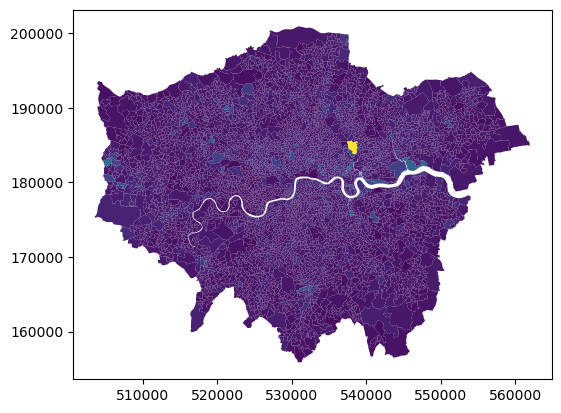

In [11]:
london_pop.plot('Persons_All-Ages')

What's going on with Stratford. Another test plot

<AxesSubplot:>

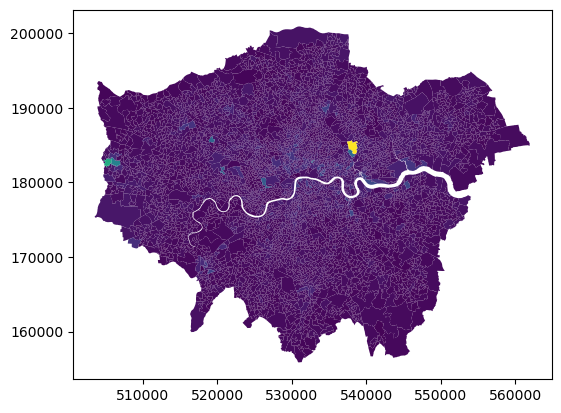

In [12]:
london_pop.plot('Males_16-29')

<AxesSubplot:>

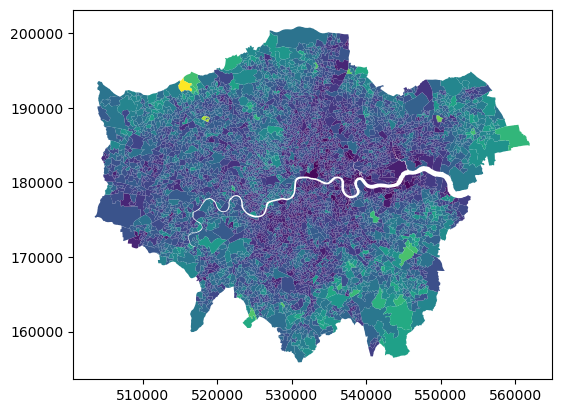

In [13]:
london_pop.plot('Females_65+')

Stratford shows up as an outlier in many maps but not all. _LSOA11CD E01033585_  See on map [here](https://www.doogal.co.uk/LSOA?code=E01033583)

In [15]:
london_pop.sort_values(by="Persons_16-29", ascending=False).head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,geometry,Persons_All-Ages,Persons_0-15,Persons_16-29,...,Males_16-29,Males_30-44,Males_45-64,Males_65+,Females_All-Ages,Females_0-15,Females_16-29,Females_30-44,Females_45-64,Females_65+
4770,E01033583,Newham 013G,E02000726,Newham 013,E09000025,Newham,"POLYGON ((538125.063 185505.000, 538125.735 18...",16004,2066,7746,...,4026,2704,664,128,7394,978,3720,1900,632,164
4812,E01033724,Hillingdon 016F,E02000509,Hillingdon 016,E09000017,Hillingdon,"POLYGON ((505395.672 183214.941, 505391.474 18...",6522,554,4273,...,2468,430,301,186,2855,272,1805,347,273,158
2362,E01002414,Hillingdon 015A,E02000508,Hillingdon 015,E09000017,Hillingdon,"POLYGON ((506009.679 183353.129, 506011.313 18...",3937,232,2864,...,1799,205,166,70,1557,92,1065,168,108,124
4809,E01033711,Hackney 027I,E02000371,Hackney 027,E09000012,Hackney,"POLYGON ((533055.956 182961.167, 533055.000 18...",3876,164,2676,...,1287,467,93,12,1920,67,1389,323,106,35
4743,E01033424,Brent 017F,E02000109,Brent 017,E09000005,Brent,"POLYGON ((519344.000 186212.000, 519346.388 18...",5175,779,2339,...,1307,761,338,47,2308,365,1032,627,226,58


The issue here is that we are mapping 2019 data on 2011 census geography. What has happened in between? A lot of development!

Checking the 2011-2021 LSOA look-up table _LSOA11_LSOA21_LAD22_EW_LU.csv_ (removed as of 2022-08-24 - see [my tweet to @ONS_Geography that day](https://twitter.com/jamesmillington/status/1562062202575749120)) shows that this 2011 LSOA is split into NINE new LSOAs in 2021 to account for the massive rise in population and households. 

So really currently these data are not really appropriate... Revisit this in future

## Write to file

Drop the spatial info to export (much smaller file, can rejoin to spatial info again infuture if needed)

In [12]:
london_pop.drop('geometry',axis=True,inplace=True)

Write to file

In [13]:
out_path = Path("../data/population/")
out_filepath = out_path/"london-mid{0}-pop.csv".format(year_str)
london_pop.to_csv(out_filepath,index=False)